## Image Classification of Cats and Dogs using CNN

## 1. Introduction
This project aims to build a deep learning-based image classifier to distinguish between images of cats and dogs using Convolutional Neural Networks (CNNs). Utilize a labeled dataset of pet images and train a neural network from scratch or using transfer learning, CNN architecture (Conv, Pooling, Flatten, Dense), Data augmentation, Accuracy/loss curves and model validation

## 2. Dataset Preparation
The following code downloads the dataset using Kaggle API, unzips it, and splits images into training and validation sets \.


In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:

!kaggle competitions download -c dogs-vs-cats


!unzip -q dogs-vs-cats.zip -d dataset
!unzip -q dataset/train.zip -d dataset/



dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace dataset/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
import os

correct_path = "dataset/train/train"
if os.path.exists(correct_path):
    images = os.listdir(correct_path)
    print(f"Images found actually: {len(images)}")
    print("Sample:", images[:5])
else:
    print("dataset/train/train not found.")


Images found actually: 25000
Sample: ['cat.1206.jpg', 'cat.10563.jpg', 'cat.11224.jpg', 'cat.2152.jpg', 'cat.1972.jpg']


## 3. Dataset Organization & Splitting
The dataset was manually divided into train and validation sets with separate folders for cats and dogs, preparing it for model training.

In [5]:
import os
import shutil
import random


original_data_dir = 'dataset/train'
base_dir = 'dataset/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')


shutil.rmtree(base_dir, ignore_errors=True)

for d in [train_cats_dir, train_dogs_dir, val_cats_dir, val_dogs_dir]:
    os.makedirs(d)


all_images = os.listdir(original_data_dir)
cats = [f for f in all_images if f.startswith('cat')]
dogs = [f for f in all_images if f.startswith('dog')]

random.shuffle(cats)
random.shuffle(dogs)

train_count = 800
val_count = 200

for i in range(train_count):
    shutil.copy(os.path.join(original_data_dir, cats[i]), train_cats_dir)
    shutil.copy(os.path.join(original_data_dir, dogs[i]), train_dogs_dir)

for i in range(train_count, train_count + val_count):
    shutil.copy(os.path.join(original_data_dir, cats[i]), val_cats_dir)
    shutil.copy(os.path.join(original_data_dir, dogs[i]), val_dogs_dir)

print("✅ Folders & images ready!")


✅ Folders & images ready!


In [6]:
print("Train Cats:", len(os.listdir(train_cats_dir)))
print("Train Dogs:", len(os.listdir(train_dogs_dir)))
print("Val Cats:", len(os.listdir(val_cats_dir)))
print("Val Dogs:", len(os.listdir(val_dogs_dir)))


Train Cats: 800
Train Dogs: 800
Val Cats: 200
Val Dogs: 200


## 4. Data Augmentation
To improve model robustness, data augmentation techniques like rotation, zoom, shear, and horizontal flipping are applied during training.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


## 5. CNN Model Architecture
A custom CNN is built with multiple convolutional and max-pooling layers, followed by dense layers and dropout to prevent overfitting.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


## 6. Model Training
The model is trained for 10 epochs with early stopping. Below is the training and validation accuracy and loss.


In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenetv2_best.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8713 - loss: 3.5812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8722 - loss: 3.5728 - val_accuracy: 0.9725 - val_loss: 0.7684
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9687 - loss: 0.9200 - val_accuracy: 0.9750 - val_loss: 0.4037
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9746 - loss: 0.3322 - val_accuracy: 0.9750 - val_loss: 0.4799
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9879 - loss: 0.1615 - val_accuracy: 0.9725 - val_loss: 0.3960
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9881 - loss: 0.0998 - val_accuracy: 0.9675 - val_loss: 0.6092
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9894 - loss: 0.0851 - val_accuracy: 0.9775 - val_loss: 0.4564
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9870 - loss: 0.0923 - val_accuracy: 0.9500 - val_loss: 1.1811
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9818 - loss: 0.2089 - val_accuracy: 0.9750 - val_loss: 0.

## 7. Training and Validation Performance
The following plots show how training/validation accuracy and loss evolved over epochs.


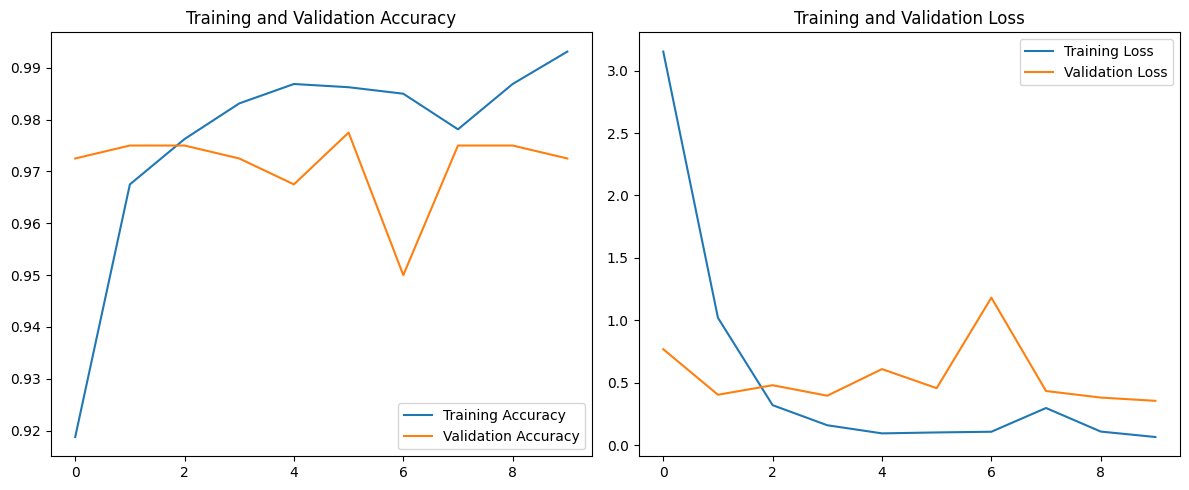

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## 8. Sample Prediction
Here is a test prediction using a single image and the trained model.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


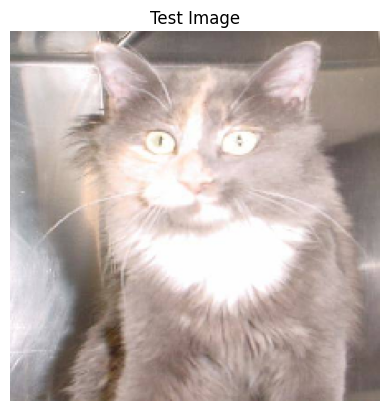

 Prediction: Cat 🐱


In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


img_path = 'dataset/train/cat.2870.jpg'


img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


prediction = model.predict(img_array)


plt.imshow(img)
plt.title("Test Image")
plt.axis("off")
plt.show()

if prediction[0][0] > 0.5:
    print(" Prediction: Dog 🐶")
else:
    print(" Prediction: Cat 🐱")

## 9. Model Saving
The trained model is saved in native `.keras` format for future use or deployment.


In [13]:
model.save("final_cnn_model.keras")

In [14]:
from google.colab import files
files.download("final_cnn_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10. Conclusion
A custom CNN was developed and trained from scratch to achieve ~97% training accuracy and ~95% validation accuracy. The model successfully distinguishes between cats and dogs.

### Acknowledgment

I would like to express my heartfelt gratitude to **Mr. Anand Maurya**, my mentor from **IBM**, under whose expert guidance and continuous support this project was successfully completed.

As a participant in the **IBM PBEL (Project-Based Experiential Learning) Program**, I had the opportunity to work on a real-world machine learning problem using deep learning techniques. Throughout the journey, Anand Maurya Sir not only provided technical assistance but also motivated me to think critically, solve problems independently, and improve my skills with each step.

His approachable nature, detailed feedback, and constant encouragement made this learning experience both meaningful and enjoyable. The PBEL program played a vital role in enhancing my understanding of AI/ML and gave me the confidence to implement practical solutions using Convolutional Neural Networks.

I sincerely thank **IBM and the entire PBEL program team** for creating such a valuable learning platform.
